In [13]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [18]:
import os
import time
import random
import itertools
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pickle
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
import joblib

from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold, StratifiedGroupKFold

from tqdm.notebook import tqdm

from src.PM_eq import penman_monteith
from src.process_fluxes import create_rolling_windows
from src.train import train

In [15]:
def scores(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    mae = mean_absolute_error(y_test, y_pred)
    return r2, rmse, mae

In [16]:
df = pd.read_csv('../data_v02/dataset.csv')
df['IGBP'] = df.IGBP.astype('category')
df

,temperature_2m,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,surface_net_solar_radiation_sum,total_evaporation_sum,surface_pressure,total_precipitation_sum,SensorZenith,SensorAzimuth,...,LE_PM_min,LE_PM_max,LE_PM_std,doy,year,lat,lon,IGBP,LE,site
0,281.343946,274.774182,-2.073795,-1.360031,26897492.0,-0.002752,99228.292806,8.702277e-07,-7688.0,1044.0,...,-8091.0,14466.0,8934.811384,144,2003,46.7305,-91.2329,DBF,19.2224,FLX_US-Wi1
1,282.464883,275.920165,-0.567736,-0.957006,25328886.0,-0.002556,99148.981283,4.280953e-06,-6919.0,5713.0,...,-8091.0,14466.0,8927.863731,145,2003,46.7305,-91.2329,DBF,24.2024,FLX_US-Wi1
2,284.084068,277.467796,-0.467478,-0.748162,27070394.0,-0.002731,99351.942220,-3.470632e-09,10194.0,989.0,...,-8091.0,14466.0,8938.041316,146,2003,46.7305,-91.2329,DBF,19.4017,FLX_US-Wi1
3,285.546112,280.368587,-0.012711,0.381809,26986822.0,-0.002901,99198.711751,1.704693e-06,-7178.0,4828.0,...,-8091.0,14466.0,8933.245569,147,2003,46.7305,-91.2329,DBF,23.7468,FLX_US-Wi1
4,287.724267,283.038661,2.504967,-0.589438,22430258.0,-0.002726,98359.807129,2.112186e-03,9959.0,2853.0,...,-8091.0,14466.0,8943.574997,148,2003,46.7305,-91.2329,DBF,42.2603,FLX_US-Wi1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100026,297.318900,287.853605,-0.168409,4.767782,14505586.0,-0.001776,97233.082194,9.688994e-05,-7574.0,2845.0,...,-16360.0,10298.0,9260.157236,254,2003,46.6347,-91.0987,DBF,55.7628,AMF_US-Wi3
100027,291.268883,287.133067,1.514562,2.380533,10545720.0,-0.001241,96738.132161,6.713572e-06,-7990.0,1027.0,...,-16360.0,10298.0,9266.910797,256,2003,46.6347,-91.0987,DBF,31.6040,AMF_US-Wi3
100028,289.352179,282.922236,2.427099,-0.343477,9703412.0,-0.001254,97260.959310,1.046062e-05,-6951.0,5714.0,...,-16360.0,10298.0,9262.322928,257,2003,46.6347,-91.0987,DBF,54.2463,AMF_US-Wi3
100029,287.695470,281.925993,3.045816,-0.182213,12917008.0,-0.001712,97294.923014,1.151973e-03,10348.0,1008.0,...,-16360.0,10348.0,9277.527589,258,2003,46.6347,-91.0987,DBF,44.2428,AMF_US-Wi3


In [5]:
'''Classical Train/Test'''
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df.drop(['LE', 'site'], axis=1), df['LE'], stratify=df['IGBP'],
                                                    test_size=0.3, shuffle=True, random_state=31)

In [5]:
'''Site-year split'''
df['site_year'] = df['site'].astype(str) + '_' + df['year'].astype(str)

site_year_igbp = df.groupby('site_year')['IGBP'].agg(lambda x: x.mode()[0]).reset_index()#for each site-year, get the dominant IGBP class

train_site_years, test_site_years = train_test_split(
    site_year_igbp['site_year'],
    test_size=0.3,
    stratify=site_year_igbp['IGBP'],
    random_state=42
)

train_df = df[df['site_year'].isin(train_site_years)]
test_df = df[df['site_year'].isin(test_site_years)]
X_train_2, y_train_2 = train_df.drop(['LE', 'site', 'site_year'], axis=1), train_df['LE']
X_test_2, y_test_2 = test_df.drop(['LE', 'site', 'site_year'], axis=1), test_df['LE']

In [6]:
data = {'classic': [X_train_1, X_test_1, y_train_1, y_test_1],
        'site_year': [X_train_2, X_test_2, y_train_2, y_test_2]}

# GroupKFold

In [6]:
df['site_year'] = df['site'].astype(str) + '_' + df['year'].astype(str)
X = df.drop(['LE', 'site', 'site_year'], axis=1)
y = df['LE']
groups = df['site_year']

results = defaultdict(lambda: {'r2': [], 'rmse': [], 'mae': []})

gkf = GroupKFold(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
    X_train, X_test = X.loc[train_idx, :], X.loc[val_idx, :]
    y_train, y_test = y.loc[train_idx], y.loc[val_idx]
    
    for model in ['LightGBM', 'XGBoost', 'RF', 'CatBoost', 'ANN']:
        y_pred = train(X_train, X_test, y_train, y_test, model)

        r2, rmse, mae = scores(y_test, y_pred)
        results[model]['r2'].append(r2)
        results[model]['rmse'].append(rmse)
        results[model]['mae'].append(mae)
        print(f'Model {model} is trained for fold #{fold}')
    
for model_name, metrics in results.items():
    print(f"\n{model_name} performance:")
    for metric_name, scores in metrics.items():
        print(f"{metric_name.upper()}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1044]	valid_0's rmse: 16.2289
Model LightGBM is trained for fold #0
Model XGBoost is trained for fold #0
Model RF is trained for fold #0
Model CatBoost is trained for fold #0
Test RMSE: 51.292		Test R2: -0.5286		 Test MAE: 44.8537
Test RMSE: 33.311		Test R2: 0.3553		 Test MAE: 21.6221
Test RMSE: 34.206		Test R2: 0.3202		 Test MAE: 21.8962
Test RMSE: 34.369		Test R2: 0.3137		 Test MAE: 21.8367
Test RMSE: 32.056		Test R2: 0.4029		 Test MAE: 20.2879
Test RMSE: 34.622		Test R2: 0.3035		 Test MAE: 21.7047
Test RMSE: 35.562		Test R2: 0.2652		 Test MAE: 22.0440
Test RMSE: 35.506		Test R2: 0.2675		 Test MAE: 22.0248
Model CatBoost is trained for fold #1
Test RMSE: 23.916		Test R2: 0.5971		 Test MAE: 17.2390
Test RMSE: 18.957		Test R2: 0.7469		 Test MAE: 14.0870
Test RMSE: 18.967		Test R2: 0.7466		 Test MAE: 14.5461
Test RMSE: 19.695		Test R2: 0.7268		 Test MAE: 15.4095
Test RMSE: 19.938		Test R2: 0

# LightGBM Feature Importance

In [41]:
plt.rcParams.update({'font.size': 20, 'font.family':'monospace', 'figure.figsize': (16, 9)})

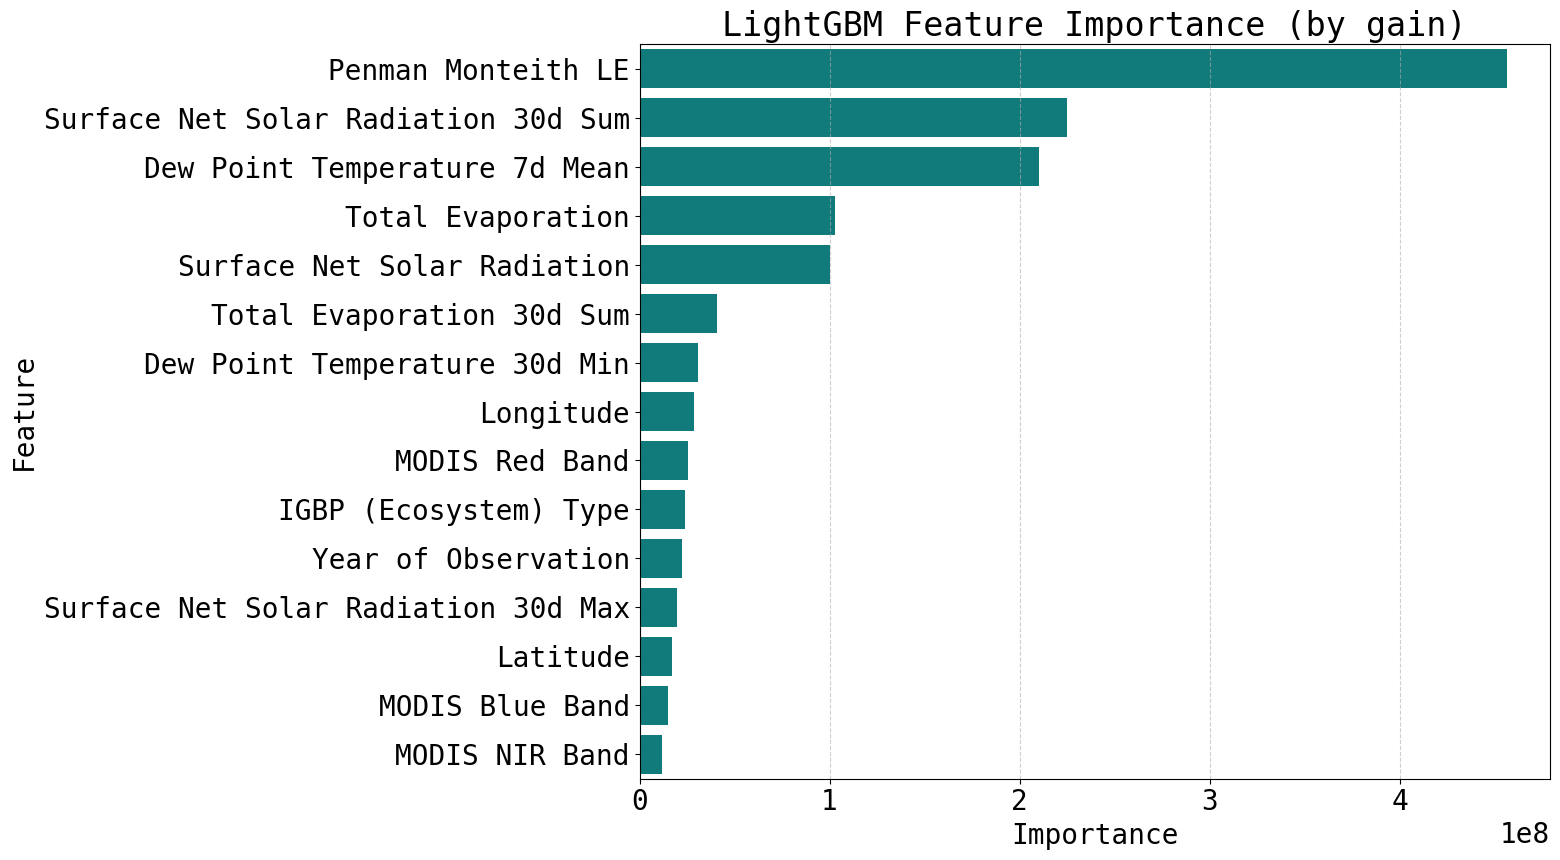

In [119]:
# df['site_year'] = df['site'].astype(str) + '_' + df['year'].astype(str)
# X = df.drop(['LE', 'site', 'site_year'], axis=1)
# y = df['LE']

# best_params = {'num_leaves': 80,
#      'learning_rate': 0.05,
#      'objective': 'regression',
#      'metric': 'rmse',
#      'boosting_type': 'gbdt',
#      'verbose': -1,
#      'num_threads': -1,
#      'colsample_bytree': 0.7}
# final_model = lgb.LGBMRegressor(**best_params)
# final_model.fit(X, y)
# joblib.dump(final_model, f'../models/lightgbm_model.txt')
final_model = joblib.load(f'../models/lightgbm_model.txt')

booster = final_model.booster_  # Access the underlying LightGBM Booster
importances_by_gain = booster.feature_importance(importance_type='gain')

fi_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances_by_gain#final_model.feature_importances_  # or 'split'
})

fi_df = fi_df.sort_values(by='importance', ascending=False)
fi_filt = (fi_df.importance - fi_df.importance.min())/(fi_df.importance.max()-fi_df.importance.min())
top_features = fi_df.loc[fi_filt.index.tolist()[:15], :].feature.index.tolist()

#custom_palette = sns.color_palette(['brown', 'darkcyan'])
fig, ax = plt.subplots(1,1,figsize=(16, 9))

sns.barplot(x='importance', y='feature', data=fi_df.loc[top_features, :], color='darkcyan', ax=ax)

ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
ax.set_title('LightGBM Feature Importance (by gain)')
ax.grid(axis='x', linestyle='--', alpha=0.6)

new_labels = ['Penman Monteith LE', 'Surface Net Solar Radiation 30d Sum', 'Dew Point Temperature 7d Mean', 'Total Evaporation', 'Surface Net Solar Radiation',
                 'Total Evaporation 30d Sum', 'Dew Point Temperature 30d Min', 'Longitude', 'MODIS Red Band', 'IGBP (Ecosystem) Type',
             'Year of Observation', 'Surface Net Solar Radiation 30d Max', 'Latitude', 'MODIS Blue Band', 'MODIS NIR Band']
ax.set_yticklabels(new_labels)
plt.tight_layout()
plt.savefig(f'../fig/LightGBM_FI.png')
plt.show()

# Seasonal and IGBP LightGBM Validation

In [98]:
df['site_year'] = df['site'].astype(str) + '_' + df['year'].astype(str)
df['IGBP'] = df.IGBP.astype('category')
X = df.drop(['LE', 'site', 'site_year'], axis=1)
y = df['LE']
groups = df['site_year']

results = defaultdict(lambda: {'r2': [], 'rmse': [], 'mae': []})

gkf = GroupKFold(n_splits=5)

IGBP_results, month_results = {}, {}
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
    X_train, X_test = X.loc[train_idx, :], X.loc[val_idx, :]
    y_train, y_test = y.loc[train_idx], y.loc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train.astype(float), categorical_feature='IGBP')
    test_data = lgb.Dataset(X_test, label=y_test.astype(float), reference=train_data, categorical_feature='IGBP')

    best_params = {'num_leaves': 80,
     'learning_rate': 0.05,
     'objective': 'regression',
     'metric': 'rmse',
     'boosting_type': 'gbdt',
     'verbose': -1,
     'num_threads': -1,
     'colsample_bytree': 0.7}

    lgbm = lgb.train(best_params, train_data, valid_sets=[test_data], num_boost_round=5000,
                    callbacks=[lgb.early_stopping(stopping_rounds=50)])
    y_pred = lgbm.predict(X_test)
    
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    for igbp, group in X_test.groupby('IGBP'):
        if len(group)>0:
            if igbp not in IGBP_results.keys():
                IGBP_results[igbp] = []
        
            IGBP_results[igbp].append(round(mean_squared_error(y_test[group.index], y_pred[group.index])**0.5,3))
    
    X_test['date'] = pd.to_datetime(X_test['year'].astype(str) + '-' + X_test['doy'].astype(str), format='%Y-%j')
    X_test['month'] = X_test['date'].dt.month
    for month, group in X_test.groupby('month'):
        if len(group)>0:
            if month not in month_results.keys():
                month_results[month] = []
        
            month_results[month].append(round(mean_squared_error(y_test[group.index], y_pred[group.index])**0.5,3))      
            
    print(f'Fold {fold} is processed!')

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1614]	valid_0's rmse: 14.4537
Fold 0 is processed!
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1918]	valid_0's rmse: 15.7541
Fold 1 is processed!
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1062]	valid_0's rmse: 16.031
Fold 2 is processed!
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2367]	valid_0's rmse: 14.5248
Fold 3 is processed!
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[730]	valid_0's rmse: 16.1474
Fold 4 is processed!


In [117]:
for key in list(IGBP_results.keys()):
    mean = round(np.mean(IGBP_results[key]),3)
    std = round(np.std(IGBP_results[key]),3)
    print(key, mean, std)

CRO 16.749 1.794
DBF 13.565 3.252
ENF 11.676 4.983
GRA 16.782 2.653
MF 6.598 1.524
WET 16.458 2.354
OSH 15.032 0.0


In [116]:
for key in list(month_results.keys()):
    mean = round(np.mean(month_results[key]),3)
    std = round(np.std(month_results[key]),3)
    print(key, mean, std)

1 3.866 0.396
2 5.309 0.603
3 8.315 1.128
4 14.087 1.54
5 22.404 3.212
6 25.834 1.382
7 24.603 1.728
8 20.674 1.274
9 18.249 0.709
10 9.798 0.719
11 5.602 0.289
12 4.018 0.529


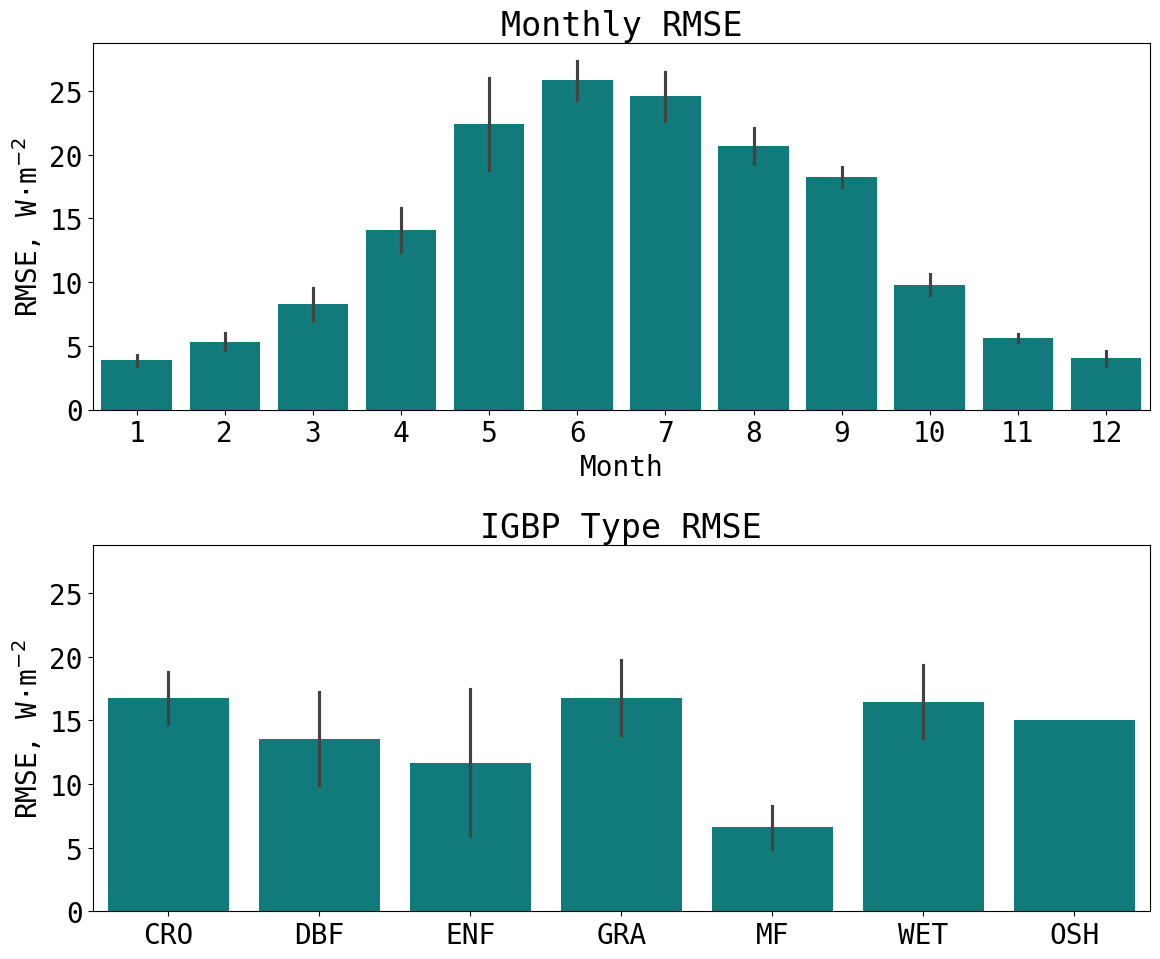

In [118]:
df_igbp = pd.DataFrame([
    {"IGBP Type": month, "Value": value}
    for month, values in IGBP_results.items()
    for value in values
])

df_month = pd.DataFrame([
    {"Month": month, "Value": value}
    for month, values in month_results.items()
    for value in values
])

#custom_palette = sns.color_palette("blend:brown,darkcyan", n_colors=12)
#custom_palette2 = sns.color_palette("blend:brown,darkcyan", n_colors=7)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=True)

# First subplot
sns.barplot(x="IGBP Type", y="Value", data=df_igbp, ci="sd", color='darkcyan', ax=axes[1])
axes[1].set_title("IGBP Type RMSE")
axes[1].set_xlabel("")
axes[1].set_ylabel("RMSE, W\u22C5m$^{-2}$")

# Second subplot
sns.barplot(x="Month", y="Value", data=df_month, ci="sd", color='darkcyan', ax=axes[0])
axes[0].set_title("Monthly RMSE")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("RMSE, W\u22C5m$^{-2}$")

plt.tight_layout()
plt.savefig('../fig/monthly_IGBP_errors.png')
plt.show()

# Train/test split based validation (old)

## LightGBM

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's rmse: 5.50958
classic------->R2: 0.981	RMSE: 5.51	MAE: 2.228
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3705]	valid_0's rmse: 12.9498
site_year------->R2: 0.896	RMSE: 12.95	MAE: 7.578


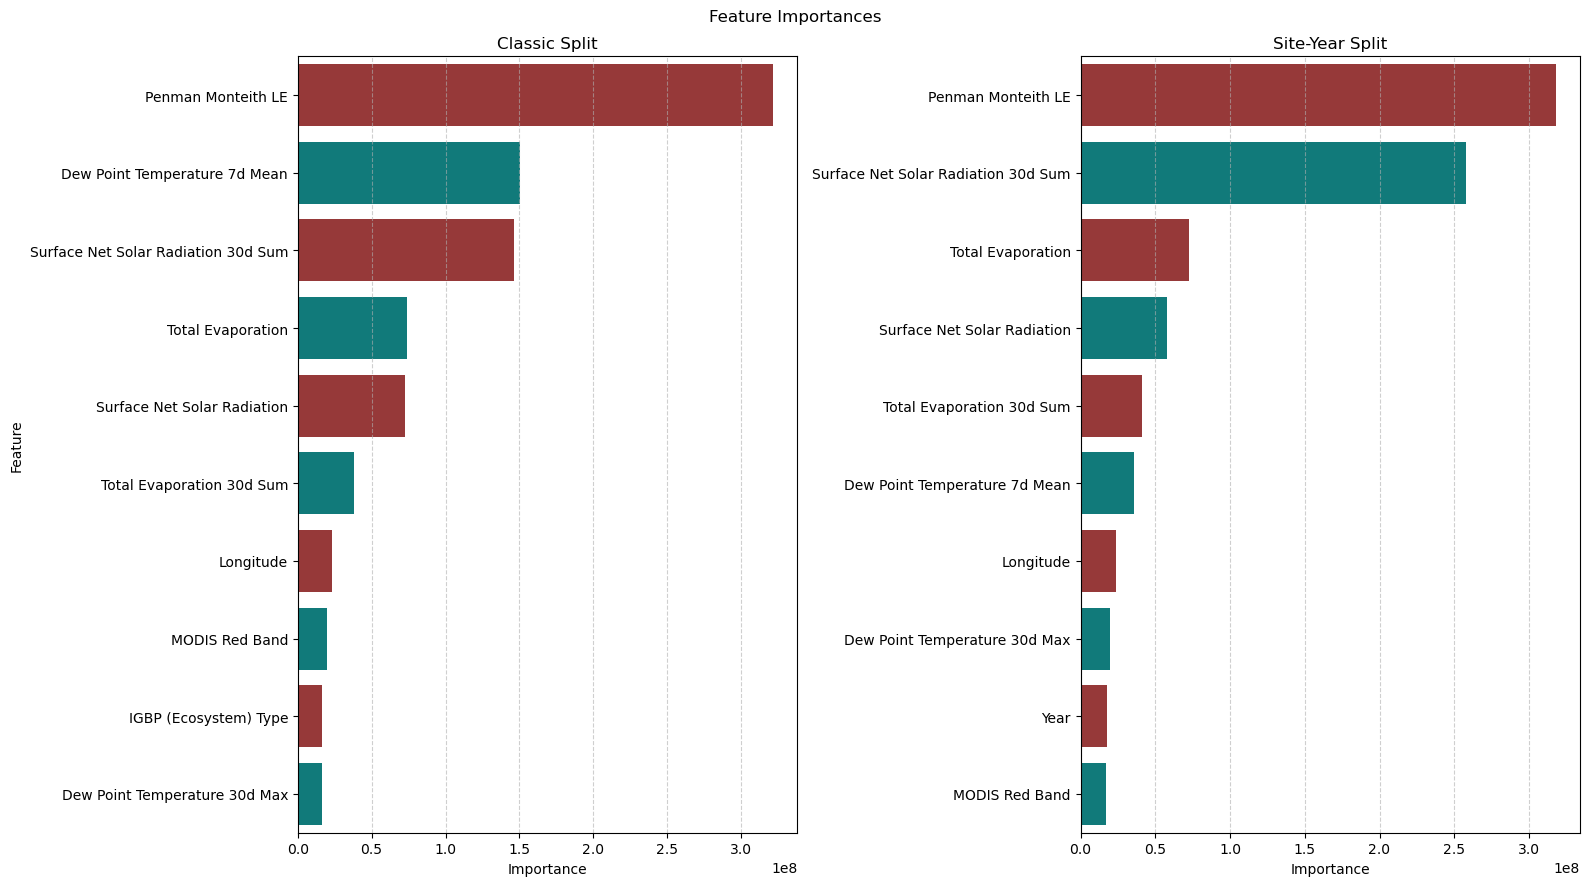

In [12]:
fig, ax = plt.subplots(1,2,figsize=(16, 9))
titles = {'classic': 'Classic Split',
         'site_year': 'Site-Year Split'}
for idx, key in enumerate(list(data.keys())):
    X_train, X_test, y_train, y_test = data[key][0], data[key][1], data[key][2], data[key][3]
    
    train_data = lgb.Dataset(X_train, label=y_train.astype(float), categorical_feature='IGBP')
    test_data = lgb.Dataset(X_test, label=y_test.astype(float), reference=train_data, categorical_feature='IGBP')

    best_params = {'num_leaves': 80,
     'learning_rate': 0.05,
     'objective': 'regression',
     'metric': 'rmse',
     'boosting_type': 'gbdt',
     'verbose': -1,
     'num_threads': -1,
     'colsample_bytree': 0.7}


    lgbm = lgb.train(best_params, train_data, valid_sets=[test_data], num_boost_round=5000,
                    callbacks=[lgb.early_stopping(stopping_rounds=50)])
    y_pred_lgb = lgbm.predict(X_test)

    print(f'{key}------->R2: {round(r2_score(y_test, y_pred_lgb),3)}\tRMSE: {round(mean_squared_error(y_test, y_pred_lgb)**0.5,3)}\tMAE: {round(mean_absolute_error(y_test, y_pred_lgb),3)}')
    
    fi_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': lgbm.feature_importance(importance_type='gain')  # or 'split'
    })

    fi_df = fi_df.sort_values(by='importance', ascending=False)
    fi_filt = (fi_df.importance - fi_df.importance.min())/(fi_df.importance.max()-fi_df.importance.min())
    top_features = fi_df.loc[fi_filt.index.tolist()[:10], :].feature.index.tolist()

    custom_palette = sns.color_palette(['brown', 'darkcyan'])
    
    sns.barplot(x='importance', y='feature', data=fi_df.loc[top_features, :], palette=custom_palette, ax=ax[idx])

    ax[idx].set_xlabel("Importance")
    if idx==0:
        ax[idx].set_ylabel("Feature")
    else:
        ax[idx].set_ylabel('')
    ax[idx].set_title(titles[key])
    ax[idx].grid(axis='x', linestyle='--', alpha=0.6)

    if idx==0:
        new_labels = ['Penman Monteith LE', 'Dew Point Temperature 7d Mean', 'Surface Net Solar Radiation 30d Sum', 'Total Evaporation', 'Surface Net Solar Radiation',
                     'Total Evaporation 30d Sum', 'Longitude', 'MODIS Red Band', 'IGBP (Ecosystem) Type', 'Dew Point Temperature 30d Max']
    else:
        new_labels = ['Penman Monteith LE', 'Surface Net Solar Radiation 30d Sum', 'Total Evaporation', 'Surface Net Solar Radiation',
                     'Total Evaporation 30d Sum', 'Dew Point Temperature 7d Mean', 'Longitude', 'Dew Point Temperature 30d Max', 'Year', 'MODIS Red Band']
    ax[idx].set_yticklabels(new_labels)

    lgbm.save_model(f'../models/lightgbm_model_{key}.txt')

plt.suptitle('Feature Importances')
plt.tight_layout()
plt.savefig(f'../fig/LightGBM_FI.png')
plt.show()

# XGBoost

In [50]:
best_params = {'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 0.6, 'n_estimators': 100, 
               'colsample_bytree': 0.9, 'subsample': 0.8, 'objective': 'reg:squarederror', 'random_state': 42, 
               'verbosity': 0, 'tree_method': 'gpu_hist', 'n_jobs': -1, 'enable_categorical': True}
for key in list(data.keys()):
    X_train, X_test, y_train, y_test = data[key][0], data[key][1], data[key][2], data[key][3]
    X_train['IGBP'] = X_train.IGBP.astype('category')
    X_test['IGBP'] = X_test.IGBP.astype('category')
    
    model =  xgb.XGBRegressor(**best_params, device="cuda")
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=0
    )

    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    model.save_model(f"../models/xgboost_model_{key}.json")
    
    print(f"{key}------->R2: {r2:.3f}\tRMSE: {rmse:.3f}\tMAE: {mae:.3f}")

classic------->R2: 0.973	RMSE: 6.685	MAE: 2.951
site_year------->R2: 0.883	RMSE: 13.715	MAE: 8.006


# RF

In [8]:
best_params = {'max_depth': 22, 'n_estimators': 100, 'random_state': 42, 'n_jobs': -1}

for key in list(data.keys()):
    X_train, X_test, y_train, y_test = data[key][0], data[key][1], data[key][2], data[key][3]
    X_train['IGBP'] = X_train.IGBP.astype('category')
    X_test['IGBP'] = X_test.IGBP.astype('category')
    
    one_hot = pd.get_dummies(X_train.IGBP)
    X_train = pd.concat([X_train.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
    one_hot = pd.get_dummies(X_test.IGBP)
    X_test = pd.concat([X_test.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
    X_test['OSH'] = [0] * len(X_test)
    
    model =  RandomForestRegressor(**best_params)
    model.fit(
        X_train, y_train
    )
    
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    with open(f"../models/rf_model_{key}.pkl", "wb") as f:
        pickle.dump(model, f)
    
    print(f"{key}------->R2: {r2:.3f}\tRMSE: {rmse:.3f}\tMAE: {mae:.3f}")

classic------->R2: 0.960	RMSE: 8.105	MAE: 4.347
site_year------->R2: 0.882	RMSE: 13.767	MAE: 8.147


# CatBoost

In [12]:
best_params = {'depth': 16,  'iterations': 2000,
                   'bootstrap_type': 'Poisson', 
                   'l2_leaf_reg': 0, 
                   'loss_function': 'RMSE', 'task_type': 'GPU', 
                   'verbose': 0, 'random_seed': 42}
    
for key in list(data.keys()):
    X_train, X_test, y_train, y_test = data[key][0], data[key][1], data[key][2], data[key][3]
    X_train['IGBP'] = X_train.IGBP.astype('category')
    X_test['IGBP'] = X_test.IGBP.astype('category')
    
    train_pool = Pool(X_train, y_train, cat_features=['IGBP'])
    test_pool = Pool(X_test, y_test, cat_features=['IGBP'])



    model = CatBoostRegressor(**best_params)
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=0)
    y_pred = model.predict(X_test)
    
    model.save_model(f"../models/catboost_model_{key}.cbm")
    
    print(f'{key}------->R2: {round(r2_score(y_test, y_pred),3)}\tRMSE: {round(mean_squared_error(y_test, y_pred)**0.5,3)}\tMAE: {round(mean_absolute_error(y_test, y_pred),3)}')

classic------->R2: 0.972	RMSE: 6.715	MAE: 2.289
site_year------->R2: 0.874	RMSE: 14.233	MAE: 8.309


# ANN

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [16]:
class Dataset():
    def __init__(self, X, Y, x_scaler=None, y_scaler=None, fit_scaler=False):
        if fit_scaler:
            self.x_scaler = MinMaxScaler()  
            self.y_scaler = MinMaxScaler()  
            X = self.x_scaler.fit_transform(X) 
            Y = self.y_scaler.fit_transform(Y.reshape(-1, 1)) 
        elif x_scaler is not None:
            X = x_scaler.transform(X)  
            Y = y_scaler.transform(Y.reshape(-1, 1)) 
            
        self.x = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(Y, dtype=torch.float32).to(device)
        self.len = self.x.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [17]:
class ANN(nn.Module):
    def __init__(self, INPUT_SIZE, n1, n2, dropout=0.3):
        super().__init__()
	
        self.net = nn.Sequential()
        self.net.add_module('Linear_1', nn.Linear(INPUT_SIZE, n1))
        self.net.add_module('ReLU_1', nn.LeakyReLU()) #Sigmoid
        self.net.add_module('Drop_1', nn.Dropout(dropout))
        
        self.net.add_module('Linear_2', torch.nn.Linear(n1, n2))
        self.net.add_module('Norm', nn.BatchNorm1d(n2))
        self.net.add_module('ReLU_2', nn.LeakyReLU())
        self.net.add_module('Drop_2', nn.Dropout(dropout))
        self.net.add_module('Linear_3',torch.nn.Linear(n2, 1))

    def forward(self, y):
        return self.net(y)

In [18]:
BATCH_SIZE = 512
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
num_epoch = 2000
feature_num = 82
n1 = 400
n2 = 100
dropout=0.3

In [28]:
for key in list(data.keys()):
    X_train, X_test, y_train, y_test = data[key][0], data[key][1], data[key][2], data[key][3]
    X_train['IGBP'] = X_train.IGBP.astype('category')
    X_test['IGBP'] = X_test.IGBP.astype('category')
    
    one_hot = pd.get_dummies(X_train.IGBP)
    X_train_ann = pd.concat([X_train.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
    one_hot = pd.get_dummies(X_test.IGBP)
    X_test_ann = pd.concat([X_test.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
    X_test_ann['OSH'] = [0] * len(X_test)
    
    train_dataset = Dataset(X_train_ann, y_train.values, fit_scaler=True)
    x_scaler = train_dataset.x_scaler 
    y_scaler = train_dataset.y_scaler 
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=False)
    test_loader = DataLoader(Dataset(X_test_ann.values, y_test.values,
                                     x_scaler=x_scaler, y_scaler=y_scaler), batch_size=BATCH_SIZE, drop_last=False)
    
    model = ANN(feature_num, n1,n2, dropout).to(device).to(torch.float32)
    
    criteria = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001) 
    
    best = -np.inf
    t0 = time.time()
    for epoch in range(num_epoch):
        model.train()
        for x, y in train_loader:
            x, y = x.to(torch.float32), y.to(torch.float32)
            pred = model(x)
            error = criteria(pred, y)

            optimizer.zero_grad()
            error.backward()
            optimizer.step()

        if epoch % 50 == 0:
            model.eval()
            test_preds = []
            test_true = []
            test_x = []
            test_idx = []
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(torch.float32), y.to(torch.float32)
                    preds = model(x)
                    preds = train_dataset.y_scaler.inverse_transform(preds.detach().cpu())
                    y_scaled = train_dataset.y_scaler.inverse_transform(y.detach().cpu())
                    test_preds.append(torch.tensor(preds))
                    test_true.append(torch.tensor(y_scaled))

            test_preds = torch.cat(test_preds).squeeze()
            test_true = torch.cat(test_true).squeeze()

            test_loss = criteria(test_preds, test_true).item()
            r2 = r2_score(test_true.numpy(), test_preds.numpy())
            mae = mean_absolute_error(test_true.numpy(), test_preds.numpy())

            best_old = best
            best = min(test_loss, best)
            if abs(best) > best_old:
                torch.save(model.state_dict(), f'../models/ANN_{key}.pth') #0.6532
                #writer.add_text("Checkpoint", "Saved model at epoch {}".format(epoch))
            print(f'Test RMSE: {test_loss**0.5:0.3f}\t\tTest R2: {r2:0.4f}\t\t Test MAE: {mae:0.4f}')
            
    model.load_state_dict(torch.load(f'../models/ANN_{key}.pth'))
    model.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(torch.float32), y.to(torch.float32)
            preds = model(x)
            preds = train_dataset.y_scaler.inverse_transform(preds.detach().cpu())
            y_scaled = train_dataset.y_scaler.inverse_transform(y.detach().cpu())
            test_preds.append(torch.tensor(preds))
            test_true.append(torch.tensor(y_scaled))

    test_preds = torch.cat(test_preds).squeeze()
    test_true = torch.cat(test_true).squeeze()

    test_loss = criteria(test_preds, test_true).item()
    r2 = r2_score(test_true.numpy(), test_preds.numpy())
    mae = mean_absolute_error(test_true.numpy(), test_preds.numpy())
    print('-'*50)
    print(f'{key}------->Validation RMSE: {test_loss**0.5:0.3f}\t\tTest R2: {r2:0.4f}\t\t Test MAE: {mae:0.4f}')
    print('-'*50)

Test RMSE: 32.907		Test R2: 0.3349		 Test MAE: 27.3100
Test RMSE: 14.219		Test R2: 0.8758		 Test MAE: 9.3930
Test RMSE: 13.462		Test R2: 0.8887		 Test MAE: 8.8722
Test RMSE: 12.794		Test R2: 0.8995		 Test MAE: 8.4032
Test RMSE: 12.857		Test R2: 0.8985		 Test MAE: 8.3569
Test RMSE: 12.197		Test R2: 0.9086		 Test MAE: 8.1122
Test RMSE: 12.314		Test R2: 0.9069		 Test MAE: 8.1059
Test RMSE: 12.296		Test R2: 0.9071		 Test MAE: 8.0798
Test RMSE: 12.088		Test R2: 0.9102		 Test MAE: 7.9337
Test RMSE: 11.617		Test R2: 0.9171		 Test MAE: 7.6939
Test RMSE: 11.800		Test R2: 0.9145		 Test MAE: 7.7669
Test RMSE: 11.378		Test R2: 0.9205		 Test MAE: 7.5287
Test RMSE: 11.205		Test R2: 0.9229		 Test MAE: 7.4143
Test RMSE: 11.283		Test R2: 0.9218		 Test MAE: 7.4668
Test RMSE: 11.123		Test R2: 0.9240		 Test MAE: 7.3988
Test RMSE: 11.011		Test R2: 0.9255		 Test MAE: 7.3612
Test RMSE: 11.092		Test R2: 0.9244		 Test MAE: 7.3861
Test RMSE: 11.030		Test R2: 0.9253		 Test MAE: 7.3681
Test RMSE: 11.000		Test R2: